# 使用神经网络模型预测生猪价格
### 模型
使用一个两层每层三个节点的神经网络
### 数据
数据是从【2014/6/24】~【2018/10/16】每周一次的价格，总共227个。
### 思路
**目标**：要预测两个月内的价格，即一共7个数据
**训练集**：【0~199】200个
**测试集**  【201~220】20个
第220个输入值应该预测228值
- 训练集输入值：【0~199】 200个
- 训练集输出值：【8~207】 200个

- 验证集的输入值：【200~219】 20个
- 验证集的输出值：【208~227】 20个

- 预测集的输入值：【220~227】 7个

In [103]:
import pandas as pd
import keras
import numpy as np

path = 'D:/homework/生猪价格预测/self/self-data/total_data.xlsx'
origin_data = pd.read_excel(path, index_col=0)

# 把标量转化为一维数组向量
origin_data = origin_data['猪肉价格'].values  # pandas 类型的数据转化为numpy类型
data = origin_data[:224]
print(len(data))
data = data.reshape(28,8)
print(data)

224
[[ 12.61  12.62  12.84  13.23  13.54  13.77  13.92  14.28]
 [ 14.62  14.94  14.98  14.95  14.92  14.77  14.73  14.57]
 [ 14.34  14.23  14.23  14.07  14.12  14.01  13.84  13.82]
 [ 13.73  13.66  13.53  13.53  13.75  13.71  13.44  13.33]
 [ 12.82  12.66  12.56  12.28  12.14  12.    12.14  12.43]
 [ 12.56  12.63  12.97  13.16  13.32  13.52  13.88  14.04]
 [ 14.22  14.52  14.64  14.84  15.1   15.79  16.37  16.71]
 [ 17.19  17.8   18.15  17.99  18.02  18.02  18.07  17.89]
 [ 17.6   17.49  17.38  17.36  17.04  16.75  16.45  16.26]
 [ 16.28  16.24  16.38  16.44  16.54  16.54  16.71  16.99]
 [ 17.58  17.7   17.89  18.12  18.1   17.92  17.99  18.14]
 [ 18.51  19.03  19.31  19.57  19.62  19.54  19.84  20.  ]
 [ 20.15  20.24  20.47  20.6   20.58  20.31  19.7   19.17]
 [ 18.53  18.16  18.29  18.18  18.07  18.31  18.48  18.41]
 [ 18.31  18.31  18.38  18.25  17.8   17.66  17.24  16.52]
 [ 16.49  16.58  16.74  16.76  16.73  16.75  16.89  16.97]
 [ 17.12  17.33  17.73  17.97  17.89  17.8   17.53  

### 如下面这样做出现了问题，train_y明明没有标准化，却发现前27个数据都被标准化了，只剩下一个没有被标准化。
- 解释：因为train_x和train_y都是指向data的指针，所以，当train_x被标准化的时候，实际上是data的前27个数据做的标准化，然后又被train_y引用。所以才出现了上面的情况。

```python
#### 一次输入向量的长度为8,使用k折检验，所以不必用单独的验证集
train_x =  data[0:27]  #
train_y =  data[1:28]

print(train_x)
print("****")
print(train_y)
print("****")
mean = train_x.mean(axis=0)
train_x -= mean
std = train_x.std(axis=0)
train_x /= std
print(train_x)
print("********")
print(train_y)
print("********")
print(train_y)
```

- 解决：使用.copy（）函数

In [104]:
#### 一次输入向量的长度为8,使用k折检验，所以不必用单独的验证集
train_x =  data[0:27]  #
train_y =  data[1:28].copy()

# print(train_x)
# print(train_y)

mean = train_x.mean(axis=0)
train_x -= mean
std = train_x.std(axis=0)
train_x /= std

# print(train_x)
# print(train_y)

In [105]:
from keras import models
from keras import layers

# 模型准备
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(8, activation = 'sigmoid', input_shape = (8,)))  # 一次输入长度为8的向量
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'relu'))
    model.add(layers.Dense(8))    # 输出长度为8的向量
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# k折检验
k = 4
num_val_samples = len(train_y) // k  # 220/4 = 55
num_epochs = 1000 # 循环200遍数据
mae_histories = []  # 装载训练集mae的列表
vmae_histories = []  # 装载验证集mae的列表
for i in range(k):
    print('processing flod # ',i)
    
    # 划分数据集
    val_data = train_x[i*num_val_samples:(i+1)*num_val_samples]
    val_label = train_y[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_x[:i*num_val_samples],train_x[(i+1)*num_val_samples:]],axis = 0)
    partial_train_label = np.concatenate([train_y[:i*num_val_samples],train_y[(i+1)*num_val_samples:]],axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_label, epochs = num_epochs, batch_size = 5,  # batch_size 的意思是每一次输入几个样例
                        validation_data=(val_data, val_label), verbose = 0)
    
    mae_history = history.history['mean_absolute_error']
    vmae_history = history.history['val_mean_absolute_error']
    mae_histories.append(mae_history)
    vmae_histories.append(vmae_history)


processing flod #  0
processing flod #  1
processing flod #  2
processing flod #  3


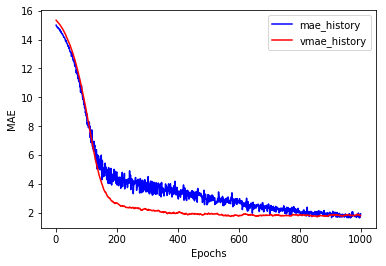

In [106]:
# list对象是没办法直接作图的，要转化为数组才行
mae_history = [np.mean([x[i] for x in mae_histories]) for i in range(num_epochs)]
vmae_history = [np.mean([x[i] for x in vmae_histories]) for i in range(num_epochs)]


import matplotlib.pyplot as plt

plt.plot(range(1, len(mae_history) + 1), mae_history,'b' ,label='mae_history')
plt.plot(range(1, len(vmae_history) + 1), vmae_history,'r', label='vmae_history')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MAE')
# plt.savefig('MAE') 
plt.show()

### 预测测试

In [109]:
# 测试输入数据准备
test_x = origin_data[218:227]
print(test_x)
test_x = test_x.reshape(1,8)
print(test_x)
# model.predict()
results = model.predict(test_x,batch_size=1, verbose=0)
print(results)

[ 14.33  14.34  14.28  13.97  13.98  13.22  12.73  12.69]
[[ 14.33  14.34  14.28  13.97  13.98  13.22  12.73  12.69]]
[[ 15.62447357  15.70388508  15.84241676  15.82102394  15.79932594
   15.83660507  15.59380531  15.52680969]]


### 预测情况mae

In [ ]:
import math
import numpy as np

# 因为没有相关数据真实label，所以无法知道
label = [14.4,14.3,14.33,14.34,14.28,13.97,13.98,13.22]

bp_data =  results
label =    np.asarray(label)

n = 8
def get_rmse(data,label):
    rmse = np.sqrt(sum((data-label)**2)/3)
    return rmse

def get_mape(data,label):
    mape = sum(abs(data-label)*100/label)/3
    return mape

def get_tic(data, label):
    s = np.sqrt(sum((data-label)**2)/3)
    l = np.sqrt(sum((np.array(data)**2)/3))
    r = np.sqrt(sum((np.array(label)**2)/3))
    return s/(l+r)

bp_rmse = get_rmse(bp_data,label)
bp_mape = get_mape(bp_data,label)
bp_tic = get_tic(bp_data,label)

print(bp_rmse,bp_mape,bp_tic)

### 小结

- **数据的加载**

    pandas加载数据.values变量为数组
    
- **改变数据形状**

    numpy的reshape()函数改变了数据的基础形状
    
- **数据改变**

    当两个新建的变量指向同一个变量时，改变其中一个，另一个也会受到“牵连”发生改变，应用.copy()函数从元数据处拷贝一份